The purpose of this notebook is to see if there are systematic differences in $\Delta F/F$ across specimens

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

from keller_zlatic_vnc.data_processing import count_unique_subjs_per_transition
from keller_zlatic_vnc.data_processing import extract_transitions
from keller_zlatic_vnc.data_processing import generate_transition_dff_table
from keller_zlatic_vnc.data_processing import read_raw_transitions_from_excel
from keller_zlatic_vnc.data_processing import recode_beh

/Users/williambishop/Documents/Janelia_Research/Projects/janelia_core/janelia_core/fileio/exp_reader.py:21: UserWarning: Unable to locate pyklb module.  Will not be able to read in .klb files.
  warnings.warn('Unable to locate pyklb module.  Will not be able to read in .klb files.')


## Parameters go here

#### Location of data

In [3]:
data_folder = r'/Volumes/bishoplab/projects/keller_vnc/data/extracted_dff_v2'
transition_file = 'transition_list.xlsx'

a00c_a4_act_data_file = 'A00c_activity_A4.mat'
a00c_a9_act_data_file = 'A00c_activity_A9.mat'

basin_a4_act_data_file = 'Basin_activity_A4.mat'
basin_a9_act_data_file = 'Basin_activity_A9.mat'

handle_a4_act_data_file = 'Handle_activity_A4.mat'
handle_a9_act_data_file = 'Handle_activity_A9.mat'

#### Options for analysis

In [4]:
# Type of cells we fit models to
cell_type = 'a00c' #a00c, basin or handle 

# Define the cutoff time we use to define quiet behaviors following stimulation
cut_off_time = np.inf

# Specify behavioral stats we will consider
beh_before = ['Q', 'F', 'B']
beh_after = ['Q', 'F', 'B']

enc_beh_interactions = False
closure = True # True if the only events we consider must start with a before_beh 
               # behavior and end with an beh_after behavior

## Specify some parameters we use in the code below

In [5]:
if cell_type == 'a00c':
    a4_act_file = a00c_a4_act_data_file
    a9_act_file = a00c_a9_act_data_file
elif cell_type == 'basin':
    a4_act_file = basin_a4_act_data_file
    a9_act_file = basin_a9_act_data_file
elif cell_type == 'handle':
    a4_act_file = handle_a4_act_data_file
    a9_act_file = handle_a9_act_data_file
else:
    raise(ValueError('The cell type ' + cell_type + ' is not recogonized.'))

## Load data

In [6]:
# Read in raw transitions
raw_trans = read_raw_transitions_from_excel(pathlib.Path(data_folder) / transition_file)

# Read in activity
a4_act = scipy.io.loadmat(pathlib.Path(data_folder) / a4_act_file, squeeze_me=True)
a9_act = scipy.io.loadmat(pathlib.Path(data_folder) / a9_act_file, squeeze_me=True)

# Correct mistake in labeling if we need to
if cell_type == 'basin' or cell_type == 'handle':
    ind = np.argwhere(a4_act['newTransitions'] == '0824L2CL')[1][0]
    a4_act['newTransitions'][ind] = '0824L2-2CL'

    # Recode behavioral annotations
raw_trans = recode_beh(raw_trans, 'Beh Before')
raw_trans = recode_beh(raw_trans, 'Beh After')

# Extract transitions
trans = extract_transitions(raw_trans, cut_off_time)

# Generate table of data 
a4table = generate_transition_dff_table(act_data=a4_act, trans=trans)
a9table = generate_transition_dff_table(act_data=a9_act, trans=trans)

# Put the tables together
a4table['man_tgt'] = 'A4'
a9table['man_tgt'] = 'A9'
data = a4table.append(a9table, ignore_index=True)

## See how many subjects we have for each type of behavior transition

In [13]:
count_unique_subjs_per_transition(data, list(set(beh_before + beh_after)))

,F,Q,B
F,14.0,0.0,1.0
Q,16.0,10.0,1.0
B,16.0,0.0,4.0


## Look at distributions of values of different transition types

In [14]:
exam_trans = [['Q', 'Q'], ['Q', 'F'], ['F', 'F'], ['B', 'F'], ['B', 'B']]
trans_clrs = ['r', 'b', 'g', 'm', 'y']
               
exam_cell_id = 3.0
value_types = 'dff_after'

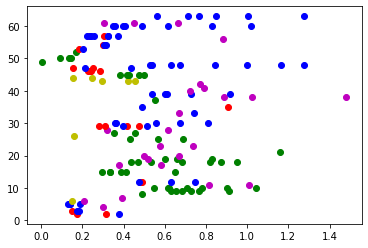

In [15]:
trans_subjs = data['subject_id'].unique()

plt.figure()
for s_i, subj in enumerate(trans_subjs):
    for t_i, trans in enumerate(exam_trans):
        before_rows = data['beh_before'] == trans[0]
        after_rows = data['beh_after'] == trans[1]
        subj_rows = data['subject_id'] == subj
        id_rows = data['cell_id'] == exam_cell_id
        keep_rows = before_rows & after_rows & subj_rows & id_rows
        vls = data[keep_rows][value_types].to_numpy()
        plt.plot(vls, s_i*np.ones_like(vls), trans_clrs[t_i] + 'o')
